<a href="https://colab.research.google.com/github/MahtabDastranj/Reinforcement-Learning/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Activation
import numpy as np
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import time

In [3]:
# Define constants for the replay memory size and model name
REPLAY_MEMORY_SIZE = 50_000  # Maximum number of experiences to store in replay memory
MODEL_NAME = '256x2'         # Model identifier (used for naming TensorBoard logs)

# Custom TensorBoard class for logging
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)  # Initialize the parent class (TensorBoard)
        self.step = 1               # Initialize step counter for logging
        self.writer = tf.summary.FileWriter(self.log_dir)  # Create a file writer for TensorBoard

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass  # Do nothing to avoid the creation of a default log writer

    # Overriding method to save logs with our step number
    # (otherwise every .fit() will start writing from the 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)  # Log custom metrics at the end of each epoch

    # Overriding method, so no logs are saved at the end of each batch
    # (We train for one batch only, so we don't need to save anything at epoch end)
    def on_batch_end(self, batch, logs=None):
        pass  # Do nothing at the end of each batch

    # Overriding method so the writer is not closed when training ends
    def on_train_end(self, _):
        pass  # Do nothing at the end of training

    # Custom method for saving our own metrics
    # Creates writer, writes custom metrics, and closes the writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)  # Log the metrics for the current step

# DQN Agent class for Deep Q-Learning
class DQNAgent:
    def __init__(self):
        # Initialize the main model for training
        self.model = self.create_model()
        # Initialize the target model, which is used for predicting Q-values
        self.target_model = self.create_model()
        # Set the target model's weights to be the same as the main model's weights
        self.target_model.set_weights(self.model.get_weights())
        # Initialize replay memory as a deque with a maximum size of REPLAY_MEMORY_SIZE
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        # Initialize TensorBoard with a custom log directory
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))
        # Initialize a counter to keep track of when to update the target model
        self.target_update_counter = 0

    # Method to create the model architecture
    def create_model(self):
        model = Sequential()  # Create a Sequential model
        # Add a convolutional layer with 256 filters and a 3x3 kernel
        model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))
        model.add(Activation('relu'))  # Apply ReLU activation function
        model.add(MaxPooling2D(2, 2))  # Apply max pooling with a 2x2 window
        model.add(Dropout(0.2))        # Apply dropout with a rate of 0.2 to prevent overfitting

        # Add another convolutional layer with 256 filters and a 3x3 kernel
        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))  # Apply ReLU activation function
        model.add(MaxPooling2D(2, 2))  # Apply max pooling with a 2x2 window
        model.add(Dropout(0.2))        # Apply dropout with a rate of 0.2 to prevent overfitting

        model.add(Flatten())  # Flatten the 2D output to 1D
        model.add(Dense(64))  # Add a fully connected layer with 64 units

        # Add the output layer with units equal to the number of possible actions
        # Use a linear activation function as we're predicting Q-values
        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))
        # Compile the model with Mean Squared Error loss and Adam optimizer
        model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model  # Return the constructed model

    # Method to update the replay memory with a new experience
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)  # Add the transition (experience) to the replay memory

    # Method to get the Q-values for a given state
    def get_qs(self, state):
        # Predict the Q-values for the given state and return the first (and only) set of predictions
        # Normalize the state input by dividing by 255 (assuming pixel values as input)
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


REPLAY_MEMORY_SIZE and MODEL_NAME:

These constants define the size of the replay memory (how many experiences it can store) and a name for the model used to label TensorBoard logs.
ModifiedTensorBoard Class:

This class extends TensorBoard to customize how logs are recorded during training. It avoids creating new log files for each .fit() call and instead uses one continuous log file. The class also customizes how metrics are logged and prevents the log writer from being closed prematurely.
DQNAgent Class:

This class defines a Deep Q-Network (DQN) agent used in reinforcement learning.
It has methods to create the neural network model, update the replay memory, and predict Q-values for a given state.
__init__ Method:
Initializes the agent's primary model for training, a target model for stable Q-value prediction, and replay memory for storing experiences.
create_model Method:
Defines the architecture of the neural network, which includes convolutional layers, activation functions, pooling layers, and dropout for regularization.
update_replay_memory Method:
Adds new experiences (state, action, reward, next state) to the replay memory.
get_qs Method:
Returns the Q-values predicted by the model for a given state.

# Q-Values

## Explanation
The formula is:

𝑄
𝑛
𝑒
𝑤
(
𝑠
𝑡
,
𝑎
𝑡
)
←
(
1
−
𝛼
)
⋅
𝑄
(
𝑠
𝑡
,
𝑎
𝑡
)
+
𝛼
⋅
(
𝑟
𝑡
+
𝛾
⋅
max
⁡
𝑎
𝑄
(
𝑠
𝑡
+
1
,
𝑎
)
)
Q
new
 (s
t
​
 ,a
t
​
 )←(1−α)⋅Q(s
t
​
 ,a
t
​
 )+α⋅(r
t
​
 +γ⋅
a
max
​
 Q(s
t+1
​
 ,a))
Components:
𝑄
𝑛
𝑒
𝑤
(
𝑠
𝑡
,
𝑎
𝑡
)
Q
new
 (s
t
​
 ,a
t
​
 ):

The updated Q-value for the state-action pair
(
𝑠
𝑡
,
𝑎
𝑡
)
(s
t
​
 ,a
t
​
 ).
(
1
−
𝛼
)
⋅
𝑄
(
𝑠
𝑡
,
𝑎
𝑡
)
(1−α)⋅Q(s
t
​
 ,a
t
​
 ):

This term represents the old value of the Q-function for the state-action pair
(
𝑠
𝑡
,
𝑎
𝑡
)
(s
t
​
 ,a
t
​
 ).
𝛼
α is the learning rate, which controls how much of the new information should be retained in the update.
The expression
(
1
−
𝛼
)
(1−α) weights the contribution of the old value.
𝛼
α (Learning Rate):

This parameter dictates how quickly the algorithm updates the Q-values.
A smaller
𝛼
α means the Q-values change slowly, while a larger
𝛼
α results in faster changes.
𝑟
𝑡
+
𝛾
⋅
max
⁡
𝑎
𝑄
(
𝑠
𝑡
+
1
,
𝑎
)
r
t
​
 +γ⋅max
a
​
 Q(s
t+1
​
 ,a):

This term is the "learned value" which the current Q-value is adjusted toward.
𝑟
𝑡
r
t
​
 : The immediate reward received after taking action
𝑎
𝑡
a
t
​
  in state
𝑠
𝑡
s
t
​
 .
𝛾
γ (Discount Factor): This parameter discounts the value of future rewards. It is a number between 0 and 1, where a value closer to 1 means future rewards are considered more significant.
max
⁡
𝑎
𝑄
(
𝑠
𝑡
+
1
,
𝑎
)
max
a
​
 Q(s
t+1
​
 ,a): This is the estimate of the optimal future value, representing the maximum Q-value for the next state
𝑠
𝑡
+
1
s
t+1
​
  across all possible actions
𝑎
a.
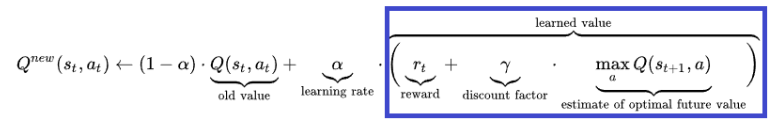